# 1. 환경설정

내용
- 파이토치 사용
- 패션, 화장품, 가전, IT기기, 생활 5가지 분야에 대한 쇼핑몰과 SNS 리뷰
- 쇼핑몰 리뷰 데이터 감성 분석
- Full Fine-Tuning & PEFT(LoRA) 활용 후 차이점 확인

데이터
- JSON 파일 하나에 여러 개의 리뷰가 포함
- RawText: 리뷰 텍스트
- GeneralPolarity: 긍부정 라벨(부정=-1, 중립=0, 긍정=1)

가이드
- 감성 분석 모델을 학습시키기 위한 형식으로 적절하게 변환
- 전체 데이터를 학습 데이터와 테스트 데이터로 분할
- transformers 라이브러리로 Full Fine-Tuning 진행
- peft 라이브러리로 PEFT(LoRA) 진행
- Full Fine-Tuning과 PEFT(LoRA) 비교 분석


In [1]:
import sys
if 'google.cloud' in sys.modules:
    from google.colab import drive; drive.mount('/content/drive')
    import drive.MyDrive.develop.projects.autoconfig as config
    config.directory('./projects/lab/250709-250714_review-sentiment-analysis/review-sentiment-analysis')
    config.font('./NanumGothic.ttf')

!ls -al



import pandas as pd
import json
from glob import glob
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BitsAndBytesConfig
from datasets import Dataset
import sys
import pandas as pd
import json
from glob import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
!pip install --upgrade datasets
from datasets import Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/develop/projects/lab/250709-250714_review-sentiment-analysis/review-sentiment-analysis
./NanumGothic.ttf 폰트 등록 완료
total 39173
-rw------- 1 root root   335649 Jul 10 16:39 01.ipynb
-rw------- 1 root root    92664 Jul 11 07:38 02.ipynb
drwx------ 2 root root     4096 Jul 10 06:47 data
-rw------- 1 root root 34970414 Jul 10 06:03 data.zip
drwx------ 2 root root     4096 Jul 10 06:25 .git
-rw------- 1 root root     4935 Jul 11 00:05 .gitignore
drwx------ 2 root root     4096 Jul 11 02:06 model
-rw------- 1 root root  4691820 Jun 21 07:09 NanumGothic.ttf
-rw------- 1 root root       27 Jul 10 06:25 README.md
drwx------ 2 root root     4096 Jul 11 04:25 results


# 2. EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184525 entries, 0 to 184524
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      184525 non-null  object
 1   source    184525 non-null  object
 2   domain    184525 non-null  object
 3   category  184525 non-null  object
 4   label     184525 non-null  int64 
 5   length    184525 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 8.4+ MB
None


/tmp/ipython-input-2-3000010112.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='source', data=df, palette='Set2')
/tmp/ipython-input-2-3000010112.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 1], x='domain', data=df, palette='Set2')
/tmp/ipython-input-2-3000010112.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1, 0], x='label', data=df, palette='Set2')
/tmp/ipython-input-2-3000010112.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed

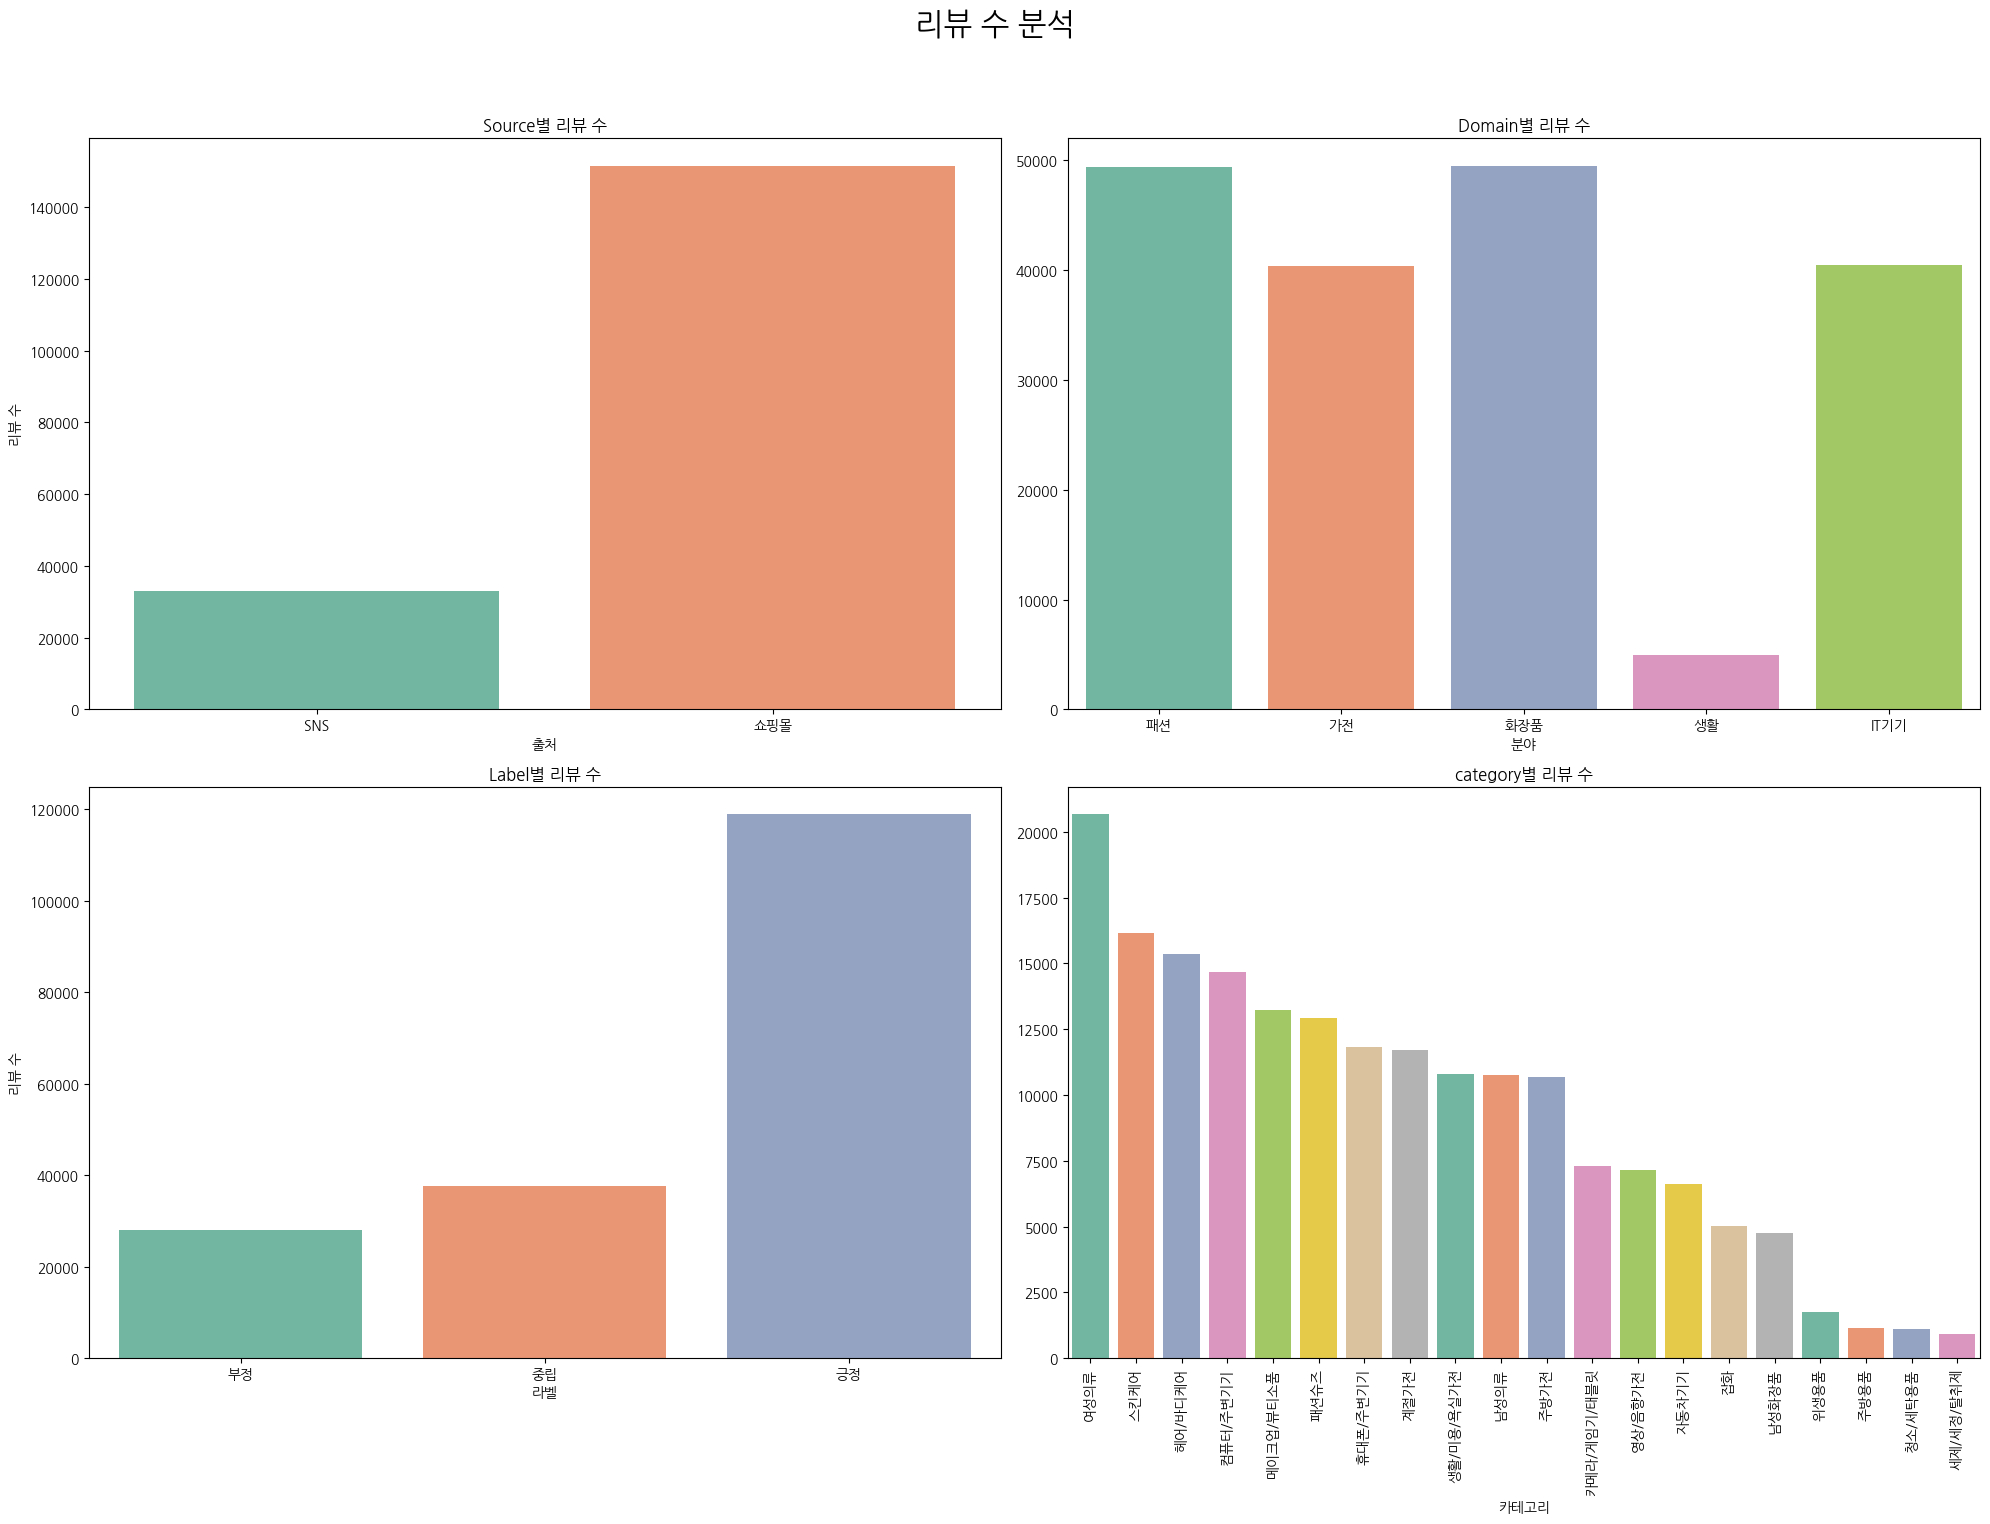

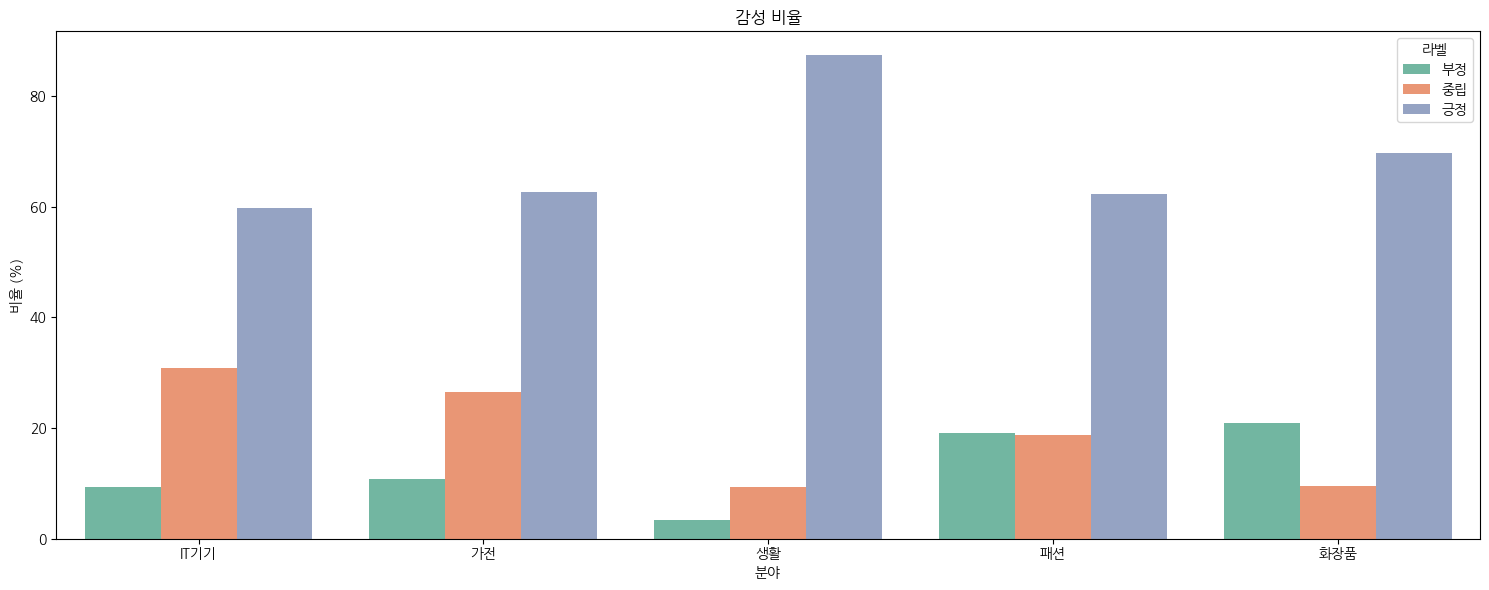

/tmp/ipython-input-2-3000010112.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=binned_counts.index.astype(str), y=binned_counts.values, palette='Set2')


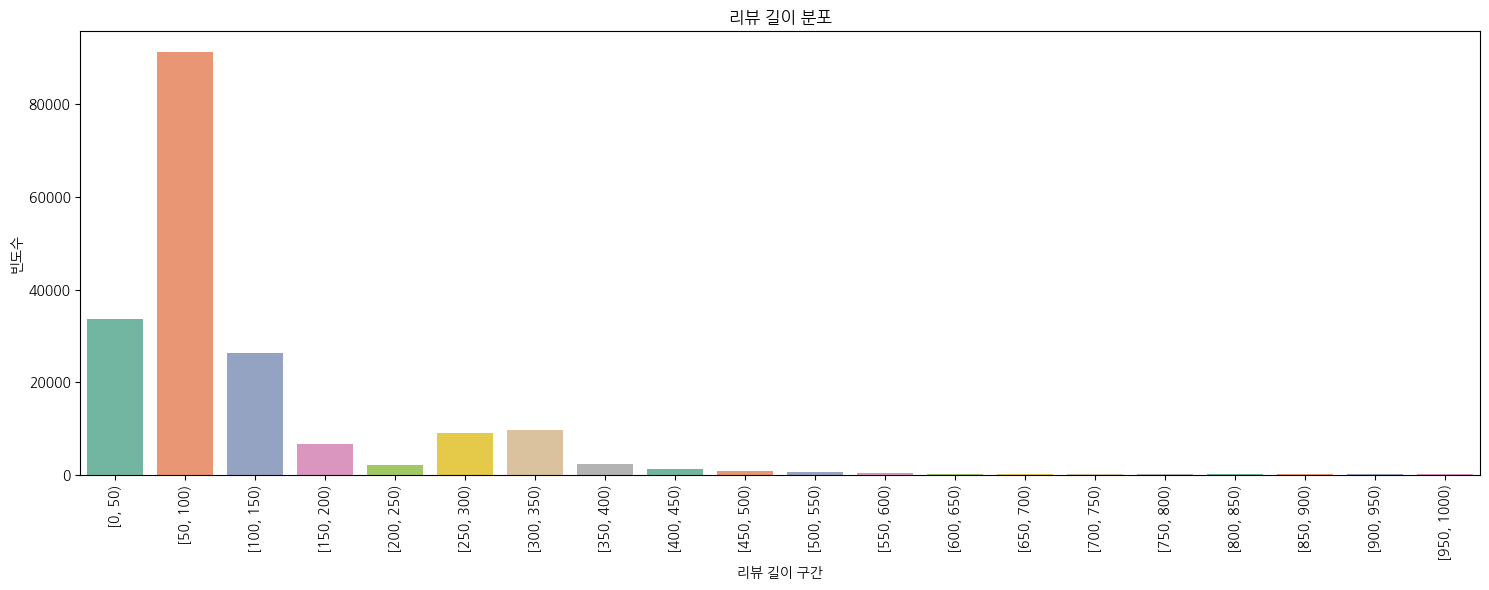

/tmp/ipython-input-2-3000010112.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], x='source', y='length', data=df, palette='Set2')
/tmp/ipython-input-2-3000010112.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], x='domain', y='length', data=df, palette='Set2')
/tmp/ipython-input-2-3000010112.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 0], x='label', y='length', data=df, palette='Set2')
/tmp/ipython-input-2-3000010112.py:138: UserWarning: set_ticklabels() should only be used with a f

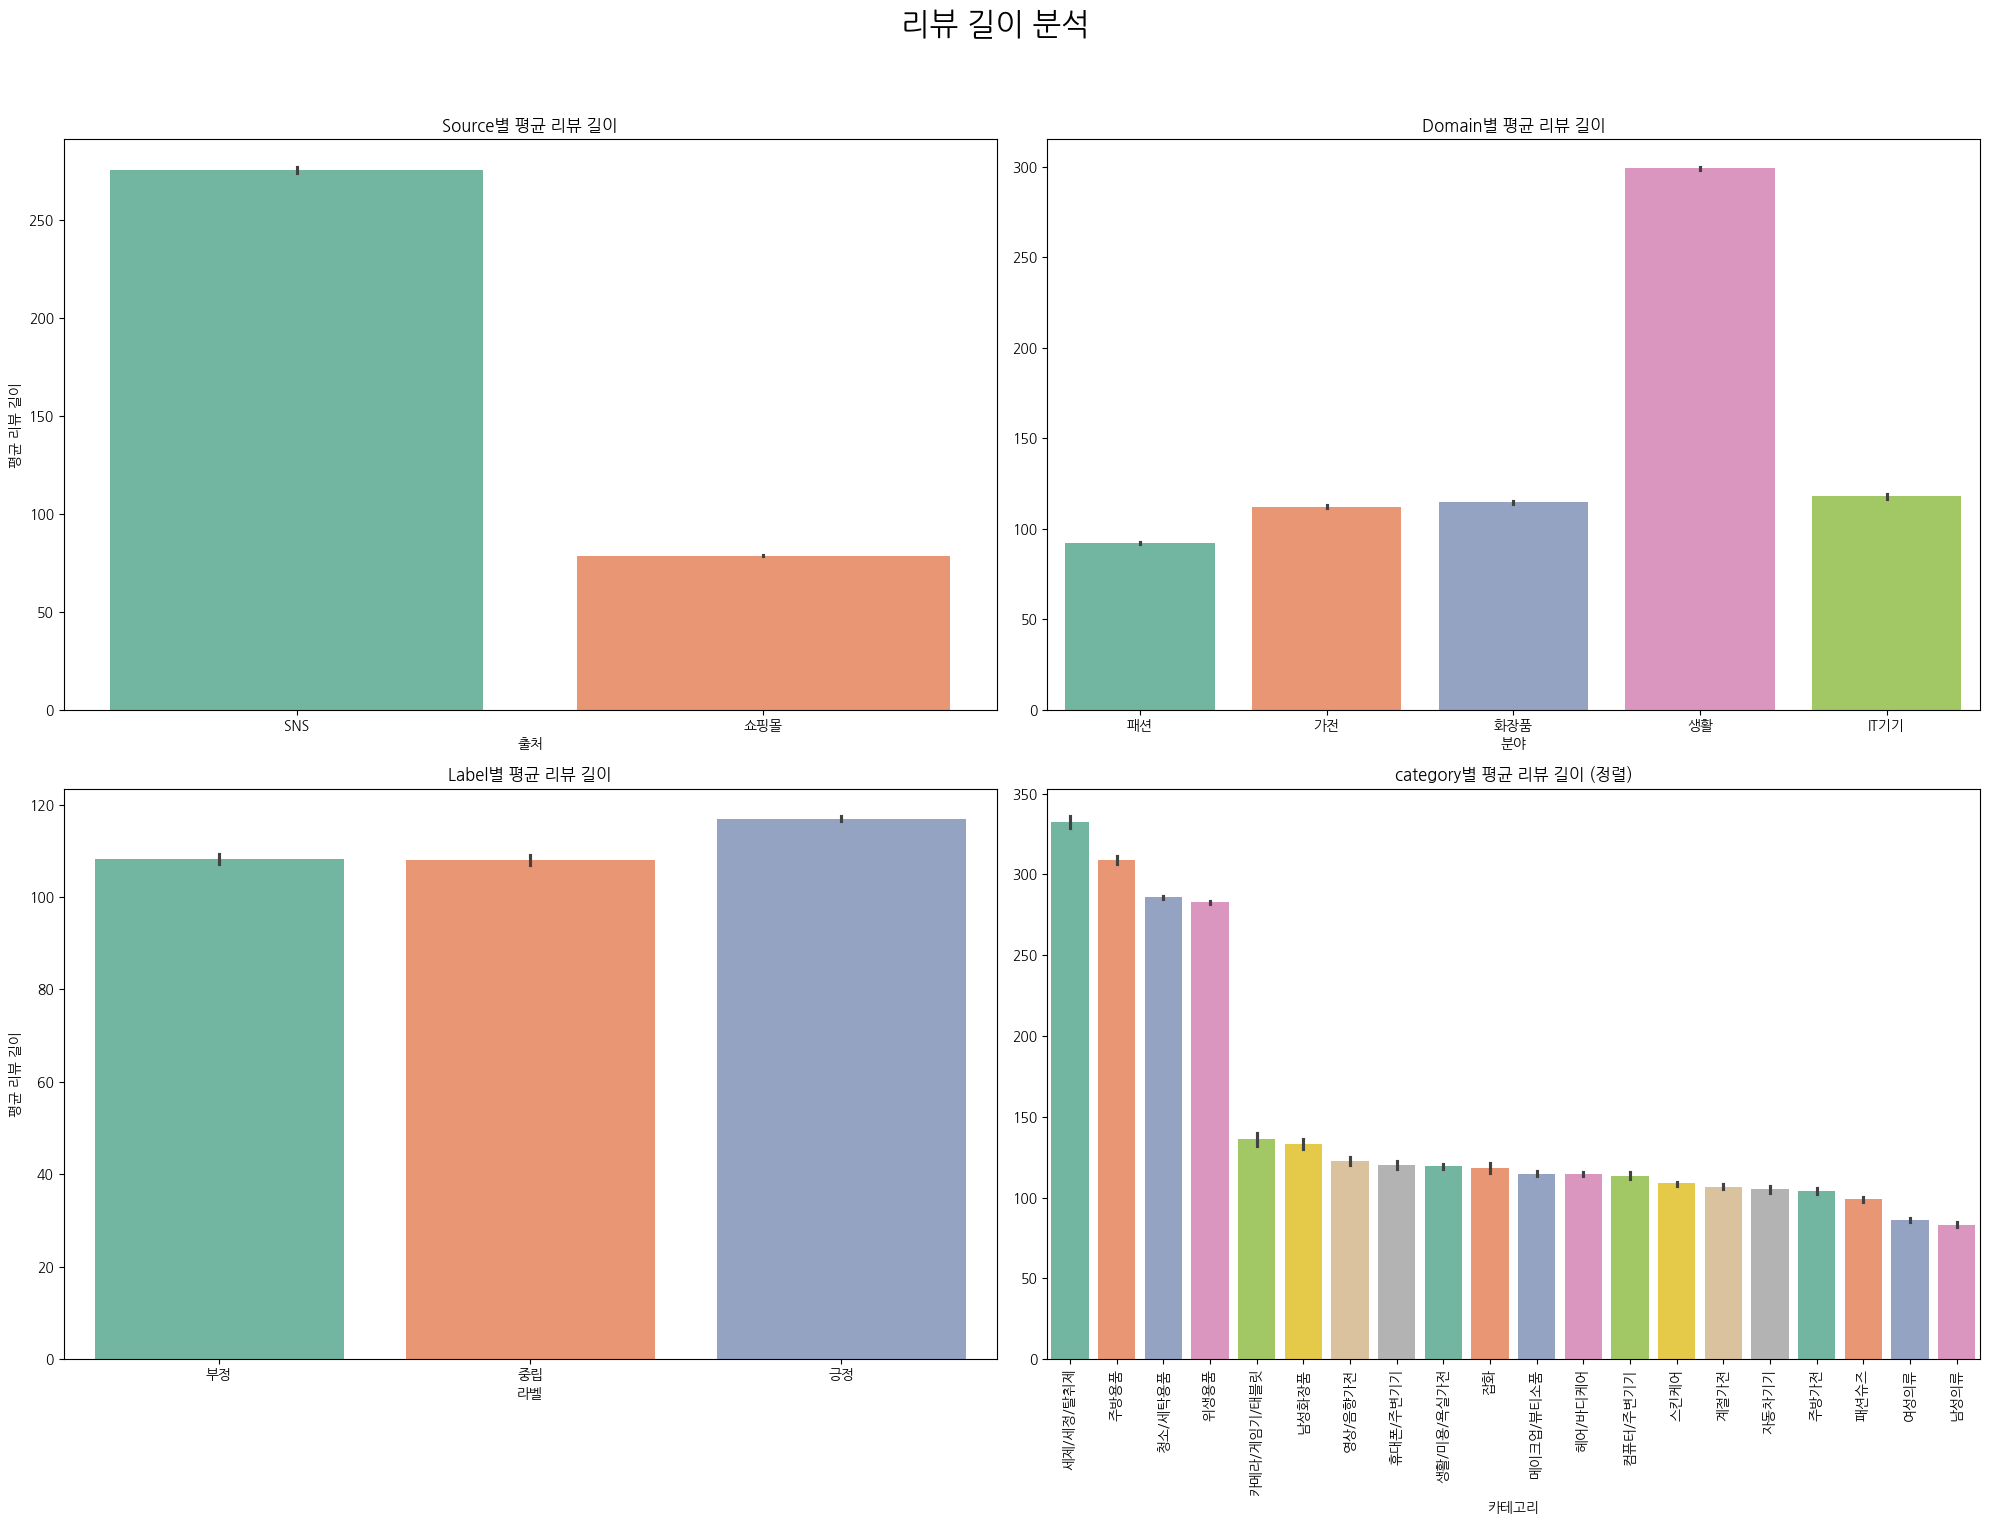

In [2]:
""" JSON 파일 로드 및 CSV 변환 함수 """
def load_json(load_dir, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    target_columns = {
        'RawText'         : 'text',
        'Source'          : 'source',
        'Domain'          : 'domain',
        'MainCategory'    : 'category',
        'GeneralPolarity' : 'label',
        'Syllable'        : 'length'
    }

    all_reviews = []

    for dir in load_dir:
        json_files = glob(os.path.join(dir, '**', '*.json'), recursive=True)

        for file_path in tqdm(json_files, desc=f"Loading '{dir}'"):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

                for review in data:
                    d = {new: review.get(old) for old, new in target_columns.items() if old in review}
                    all_reviews.append(d)

    df = pd.DataFrame(all_reviews)

    df.dropna(inplace=True)
    df['label'] = pd.to_numeric(df['label']).apply(lambda x: int(x) + 1)
    df['length'] = pd.to_numeric(df['length'])

    df.to_csv(os.path.join(save_dir, 'reviews.csv'), index=False, encoding='utf-8-sig')

    return df


""" CSV 저장 """
# load_json(['./data/SNS/', './data/쇼핑몰/'], './data')


""" CSV 로드 """
df = pd.read_csv('./data/reviews.csv')


""" 정보 확인 """
print(df.info())


""" 리뷰 수 분석 """
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('리뷰 수 분석', fontsize=22)

# Source별 리뷰 수
sns.countplot(ax=axes[0, 0], x='source', data=df, palette='Set2')
axes[0, 0].set_title('Source별 리뷰 수')
axes[0, 0].set_xlabel('출처')
axes[0, 0].set_ylabel('리뷰 수')

# Domain별 리뷰 수
sns.countplot(ax=axes[0, 1], x='domain', data=df, palette='Set2')
axes[0, 1].set_title('Domain별 리뷰 수')
axes[0, 1].set_xlabel('분야')
axes[0, 1].set_ylabel('')

# Label별 리뷰 수
sns.countplot(ax=axes[1, 0], x='label', data=df, palette='Set2')
axes[1, 0].set_title('Label별 리뷰 수')
axes[1, 0].set_xlabel('라벨')
axes[1, 0].set_ylabel('리뷰 수')
axes[1, 0].set_xticks(ticks=[0, 1, 2])
axes[1, 0].set_xticklabels(['부정', '중립', '긍정'])

# Category별 리뷰 수
top_20_categories = df['category'].value_counts().head(20).index
sns.countplot(ax=axes[1, 1], x='category', data=df, order=top_20_categories, palette='Set2')
axes[1, 1].set_title('category별 리뷰 수')
axes[1, 1].set_xlabel('카테고리')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


""" 감성 비율 """
domain_label_ratio = df.groupby('domain')['label'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(ax=ax, x='domain', y='percent', hue='label', data=domain_label_ratio, palette='Set2')
ax.set_title('감성 비율')
ax.set_xlabel('분야')
ax.set_ylabel('비율 (%)')
ax.legend(handles=ax.get_legend_handles_labels()[0], title='라벨', labels=['부정', '중립', '긍정'])
plt.tight_layout()
plt.show()


""" 리뷰 길이 분포 """
max_len = df['length'].max()
step = 50
bin_edges = np.arange(0, max_len + step, step)
bins = pd.cut(df['length'], bins=bin_edges, right=False)
binned_counts = bins.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(ax=ax, x=binned_counts.index.astype(str), y=binned_counts.values, palette='Set2')
ax.set_title('리뷰 길이 분포')
ax.set_xlabel('리뷰 길이 구간')
ax.set_ylabel('빈도수')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


""" 리뷰 길이 분석 """
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('리뷰 길이 분석', fontsize=22)

# Source별 평균 길이
sns.barplot(ax=axes[0, 0], x='source', y='length', data=df, palette='Set2')
axes[0, 0].set_title('Source별 평균 리뷰 길이')
axes[0, 0].set_xlabel('출처')
axes[0, 0].set_ylabel('평균 리뷰 길이')

# Domain별 평균 길이
sns.barplot(ax=axes[0, 1], x='domain', y='length', data=df, palette='Set2')
axes[0, 1].set_title('Domain별 평균 리뷰 길이')
axes[0, 1].set_xlabel('분야')
axes[0, 1].set_ylabel('')

# Label별 평균 길이
sns.barplot(ax=axes[1, 0], x='label', y='length', data=df, palette='Set2')
axes[1, 0].set_title('Label별 평균 리뷰 길이')
axes[1, 0].set_xlabel('라벨')
axes[1, 0].set_ylabel('평균 리뷰 길이')
axes[1, 0].set_xticklabels(['부정', '중립', '긍정'])

# Category별 평균 길이
top_20_categories = df['category'].value_counts().head(20).index
top_20_df = df[df['category'].isin(top_20_categories)]
sorted_order = top_20_df.groupby('category')['length'].mean().sort_values(ascending=False).index
sns.barplot(ax=axes[1, 1], x='category', y='length', data=top_20_df, order=sorted_order, palette='Set2')
axes[1, 1].set_title('category별 평균 리뷰 길이 (정렬)')
axes[1, 1].set_xlabel('카테고리')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. 모델 & 데이터셋 생성

In [3]:
# model_name = "FacebookAI/xlm-roberta-base"
# save_dir = "./model/"

# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.save_pretrained(save_dir)

# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
# model.save_pretrained(save_dir)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

model_path = "./model"  # FacebookAI/xlm-roberta-base
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize(examples):
    tokenized = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )
    return tokenized


tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)

tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

Map:   0%|          | 0/147620 [00:00<?, ? examples/s]

Map:   0%|          | 0/36905 [00:00<?, ? examples/s]

# 4. 모델 학습

In [12]:
""" 학습 중 출력할 지표 설정 """
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": accuracy, "f1": f1}


""" 모델 학습 함수 """
def train_model(model, args):
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    return trainer


""" 학습 인자 설정 함수 """
def set_train_args(output_dir):
    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=10,
        per_device_train_batch_size=512,
        per_device_eval_batch_size=512,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        save_total_limit=2,
        report_to="none",
    )
    return args


""" Full Fine Tunning 학습 """
model_fft = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3, torch_dtype=torch.bfloat16).to(device)
args_fft = set_train_args(output_dir='./results/fft')

train_fft = train_model(model_fft, args_fft).train()


""" PEFT LoRA 학습 """
lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=64, lora_alpha=128, lora_dropout=0.1)
model_lora = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3, torch_dtype=torch.bfloat16).to(device)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()
args_lora = set_train_args(output_dir='./results/lora')

train_lora = train_model(model_lora, args_lora).train()

/tmp/ipython-input-12-4181049620.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.262137,0.892860,0.893262
2,0.329800,0.250653,0.898198,0.899594
3,0.329800,0.240106,0.901477,0.900622
4,0.238000,0.239436,0.903211,0.903429
5,0.238000,0.238138,0.903834,0.904475
6,0.222000,0.237161,0.904322,0.904204
7,0.213200,0.236434,0.905216,0.905001
8,0.213200,0.237155,0.905026,0.905091
9,0.209200,0.236669,0.905135,0.905259
10,0.209200,0.236923,0.905297,0.905357


/tmp/ipython-input-12-4181049620.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 2,952,195 || all params: 280,998,150 || trainable%: 1.0506


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.293894,0.882834,0.882448
2,0.405100,0.283734,0.890150,0.890354
3,0.405100,0.277431,0.891857,0.890097
4,0.282200,0.268705,0.894052,0.894652
5,0.282200,0.260552,0.895597,0.896090
6,0.265800,0.255127,0.898035,0.897725
7,0.257500,0.255640,0.898821,0.898979
8,0.257500,0.252139,0.898794,0.899119
9,0.253100,0.254619,0.899553,0.899549
10,0.253100,0.253639,0.899905,0.899930


In [ ]:
`

# 5. 모델 평가

In [ ]:
`

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Full Fine-Tuning 모델 경로
fft_model_path = './results/full_finetuning/checkpoint-1445' # 'checkpoint-...' 부분은 실제 저장된 폴더명으로 수정해야 해!

# 모델과 토크나이저 불러오기
model_fft = AutoModelForSequenceClassification.from_pretrained(fft_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(fft_model_path)

print("✅ Full Fine-Tuning 모델 로드 완료!")
print(model_fft)

In [ ]:
from peft import PeftModel
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 베이스 모델 경로
base_model_path = "./model" # FacebookAI/xlm-roberta-base

# LoRA 어댑터(학습된 가중치) 경로
lora_model_path = './results/lora/checkpoint-1445' # 'checkpoint-...' 부분은 실제 저장된 폴더명으로 수정!

# 베이스 모델 먼저 불러오기 (bfloat16 타입으로)
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_path,
    num_labels=3,
    torch_dtype=torch.bfloat16
)

# LoRA 모델(어댑터) 덮어쓰기
model_lora = PeftModel.from_pretrained(base_model, lora_model_path).to(device)

print("\n✅ LoRA 모델 로드 완료!")
print(model_lora)

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# 평가 지표 계산 함수 (이전에 정의했던 것과 동일)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

# 평가를 위한 TrainingArguments 설정
eval_args = TrainingArguments(
    output_dir='./results/eval',
    per_device_eval_batch_size=512, # 배치 사이즈는 환경에 맞게 조절
    report_to="none"
)

# 1. Full Fine-Tuning 모델 평가
trainer_fft = Trainer(
    model=model_fft,
    args=eval_args,
    eval_dataset=tokenized_test_dataset, # 이전에 만들어둔 테스트 데이터셋
    compute_metrics=compute_metrics
)
fft_metrics = trainer_fft.evaluate()
fft_metrics['model'] = 'Full Fine-Tuning'


# 2. LoRA 모델 평가
trainer_lora = Trainer(
    model=model_lora,
    args=eval_args,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)
lora_metrics = trainer_lora.evaluate()
lora_metrics['model'] = 'LoRA'


# 3. 결과 비교
results_df = pd.DataFrame([fft_metrics, lora_metrics])
results_df = results_df.set_index('model') # 모델 이름을 인덱스로 설정
print("--- 모델 성능 평가 결과 ---")
print(results_df[['eval_loss', 'eval_accuracy', 'eval_f1']])

In [ ]:
import torch
import torch.nn.functional as F

# 테스트해 볼 샘플 리뷰
sample_text = "디자인은 예쁜데, 배송이 너무 느려서 실망했어요."

# 감성 예측 함수
def predict_sentiment(model, tokenizer, text):
    model.eval() # 모델을 평가 모드로 설정

    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()

    labels = ['부정', '중립', '긍정']

    # return labels[prediction], probs.cpu().numpy()[0]
    return labels[prediction], probs.cpu().float().numpy()[0]

# 1. Full Fine-Tuning 모델 예측
fft_prediction, fft_probs = predict_sentiment(model_fft, tokenizer, sample_text)
print("--- Full Fine-Tuning 모델 예측 결과 ---")
print(f"리뷰: {sample_text}")
print(f"예측 감성: {fft_prediction}")
print(f"확률 (부정, 중립, 긍정): {fft_probs}\n")


# 2. LoRA 모델 예측
lora_prediction, lora_probs = predict_sentiment(model_lora, tokenizer, sample_text)
print("--- LoRA 모델 예측 결과 ---")
print(f"리뷰: {sample_text}")
print(f"예측 감성: {lora_prediction}")
print(f"확률 (부정, 중립, 긍정): {lora_probs}")